### **IdentiPay** - Fare Payment System of Azerbaijan based on Face Identification

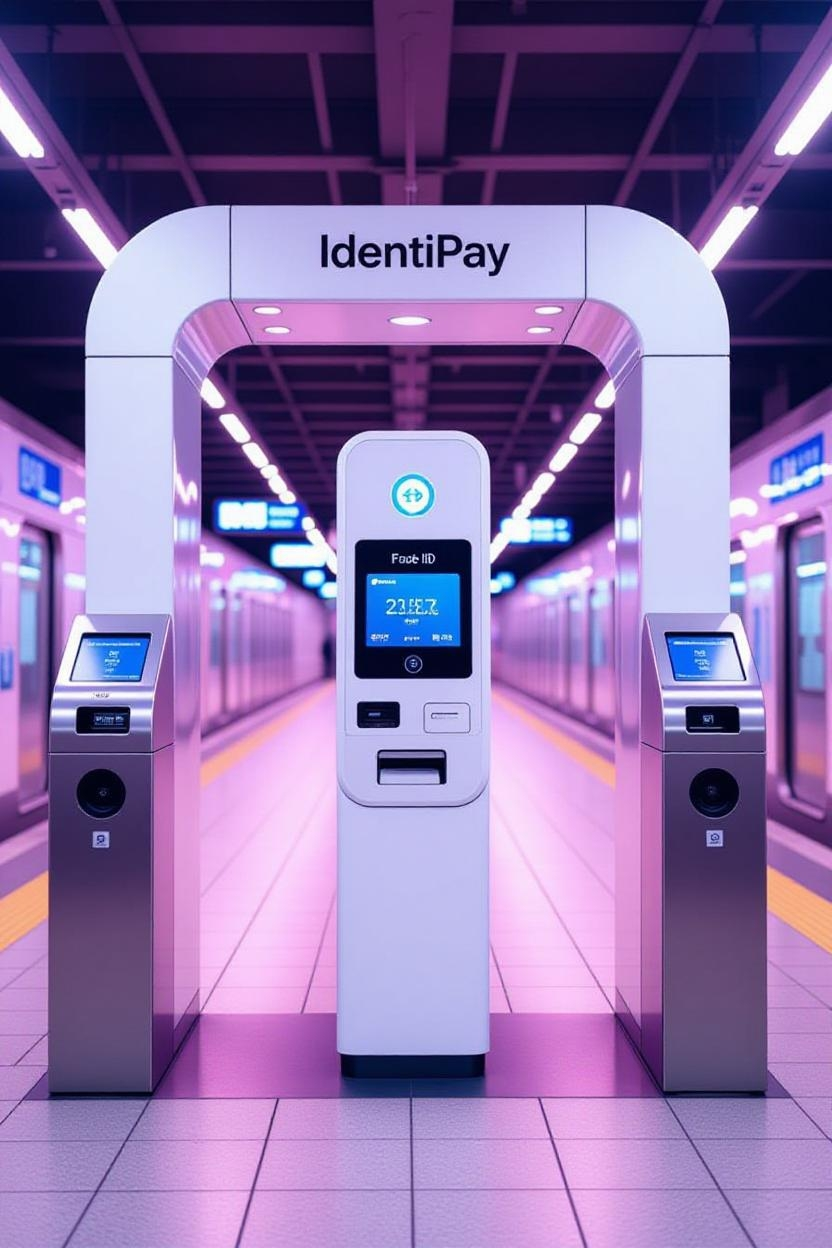

Firstly we have to install `facenet_pytorch` library in order for model to handle an abundant amount of face prototypes.

In [1]:
pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [1]:
import kagglehub
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import glob
import pickle
from collections import deque
from google.colab import files
import hashlib
from datetime import datetime
import gradio as gr

In [2]:
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

Using Colab cache for faster access to the 'lfw-dataset' dataset.


The code downloads the LFW (Labeled Faces in the Wild) dataset using the kagglehub library and prints its local storage path

In [3]:
device = 'cpu'
mtcnn = MTCNN(keep_all = False, device = 'cpu')
resnet = InceptionResnetV1(pretrained = 'vggface2').eval().to('cpu')
resnet.eval()

print("Finished successfully!")

  0%|          | 0.00/107M [00:00<?, ?B/s]

Finished successfully!


1) MTCNN **(Multi-task Cascaded Convolutional Neural Network)** for face fetection sets up the model to detect faces in images, returning only the most confident detection *(keep_all = False)* and running on the CPU *(device = 'cpu')*.

2) Loads a pre-trained FaceNet model (InceptionResnetV1) using the (VGGFace2) dataset to create 512-D facial embeddings. *eval()* sets it to evaluation mode, and *to('cpu')* runs it on the CPU.

In [4]:
# user database will look like: {user_id: {name, path, balance}}
users_db = {}

# trip logs: list of {user_id, entry_station, entry_time, exit_station, exit_time, fare}
trip_logs = []

# Save database
def save_db():
    with open('users_db.pkl', 'wb') as f: pickle.dump(users_db, f)
    with open('trip_logs.pkl', 'wb') as f: pickle.dump(trip_logs, f)

# Metro stations with distances | Only Red line of Baku metro so far (Həzi Aslanov - İçərişəhər)
stations = {
    'Həzi Aslanov': {'Əhmədli': 1.4, 'Xalqlar Dostluğu': 2.7, 'Neftçilər': 4.3, 'Qara Qarayev': 5.5,
                     'Koroğlu': 6.9, 'Ulduz': 9.2, 'Nəriman Nərimanov': 11.4, 'Gənclik': 13.1,
                     '28 May': 15.4, 'Sahil': 16.4, 'İçərişəhər': 17.6},

    'Əhmədli': {'Xalqlar Dostluğu': 1.3, 'Neftçilər': 3, 'Qara Qarayev': 4.1, 'Koroğlu': 5.5,
                'Ulduz': 7.8, 'Nəriman Nərimanov': 10, 'Gənclik': 11.7, '28 May': 14, 'Sahil': 15,
                'İçərişəhər': 16.2},

    'Xalqlar Dostluğu': {'Neftçilər': 1.7, 'Qara Qarayev': 2.8, 'Koroğlu': 4.2, 'Ulduz': 6.5,
                         'Nəriman Nərimanov': 8.7, 'Gənclik': 10.4, '28 May': 12.7, 'Sahil': 13.7,
                         'İçərişəhər': 14.9},

    'Neftçilər': {'Qara Qarayev': 1.1, 'Koroğlu': 2.5, 'Ulduz': 4.8, 'Nəriman Nərimanov': 7,
                  'Gənclik': 8.7, '28 May': 11, 'Sahil': 12, 'İçərişəhər': 13.2},

    'Qara Qarayev': {'Koroğlu': 1.4, 'Ulduz': 3.7, 'Nəriman Nərimanov': 5.9, 'Gənclik': 7.6,
                     '28 May': 9.9, 'Sahil': 10.9, 'İçərişəhər': 12.1},

    'Koroğlu': {'Ulduz': 2.3, 'Nəriman Nərimanov': 4.5, 'Gənclik': 6.2, '28 May': 8.5, 'Sahil': 9.5,
                'İçərişəhər': 10.7},

    'Ulduz': {'Nəriman Nərimanov': 2.2, 'Gənclik': 4.9, '28 May': 6.3, 'Sahil': 7.3, 'İçərişəhər': 8.4},

    'Nəriman Nərimanov': {'Gənclik': 3.7, '28 May': 4.1, 'Sahil': 5.1, 'İçərişəhər': 6.3},

    'Gənclik': {'28 May': 0.4, 'Sahil': 1.4, 'İçərişəhər': 2.6},

    '28 May': {'Sahil': 1, 'İçərişəhər': 2.2},

    'Sahil': {'İçərişəhər': 1.2},

    'İçərişəhər': {0: 0}}
station_list = list(stations.keys())

embedding_dir = "embeddings"
os.makedirs(embedding_dir, exist_ok = True)

print("Finished successfully!")

Finished successfully!


1) *users_db = {}* initializes an empty dictionary to store user information, where each user_id maps to details like name, path (likely for face embeddings), and balance for fare payments.
2) *trip_logs = []* creates an empty list to record trip details, including user_id, entry_station, entry_time, exit_station, exit_time, and fare.
3) *stations = {...}* defines a dictionary of metro stations with distances to other stations. Each station maps to a dictionary of connected stations and their respective distances, representing the metro network.
4) *embedding_dir = "embeddings"* sets the directory name for storing face embeddings, and *os.makedirs(embedding_dir, exist_ok = True)* creates this directory if it doesn’t exist, ensuring no errors if it already does.

In [5]:
def extract_face_embedding(image):
    if image is None: return None

    img = Image.fromarray(image).convert('RGB')
    face = mtcnn(img)

    if face is None: return None

    embedding = resnet(face.unsqueeze(0)).detach().numpy().flatten()
    return embedding

def find_closest_user(query_embedding, threshold = 0.7):

    best_match = None
    best_score = -1

    for user_id, data in users_db.items():
        stored_embedding = np.load(data['embedding_path'])
        sim = cosine_similarity([query_embedding], [stored_embedding])[0][0]
        if sim > best_score and sim >= threshold:
            best_score = sim
            best_match = user_id

    return best_match, best_score

Initially, the code defines two functions for a Face ID payment system, handling face embedding extraction and user identification via cosine similarity.

1) *extract_face_embedding(image_path)*, the function processes an image to generate a facial embedding for recognition.
- *img = Image.open(image_path).convert('RGB')* opens the image and converts it to RGB format.
- *face = mtcnn(img)* uses the MTCNN model to detect and extract a face from the image. Returns None if no face is detected.
- *embedding = resnet(face.unsqueeze(0)).detach().numpy().flatten()* passes the detected face through the model to generate a 512-D embedding, converted to a NumPy array and flattened.


2) *find_closest_user(query_embedding, threshold = 0.7)*, this function identifies the user whose stored embedding is most similar to the query embedding, using cosine similarity. Iterates through users_db to compare the query_embedding with each user’s stored embedding.

- *sim = cosine_similarity()* computes cosine similarity between the query and stored embeddings.
Tracks the best_match (user ID) and best_score (highest similarity) if the similarity exceeds the threshold (default 0.7). As a result, returns a tuple of the best matching user_id and its similarity score, or (None, -1) if no match exceeds the threshold.

In [7]:
def calculate_shortest_distance(start, end):

    if start == end: return 0
    if start not in stations or end not in stations: return None

    queue = deque([(start, 0)])
    visited = set()

    while queue:
        current, dist = queue.popleft()

        if current == end: return dist
        if current in visited:
          continue

        visited.add(current)

        for neighbor, edge_dist in stations[current].items():
            if neighbor not in visited: queue.append((neighbor, dist + edge_dist))

    return None

def calculate_fare(distance_km):
    # Simple fare formula: (0.5)AZN base + (0.01)AZN per km
    if distance_km is None or distance_km < 1.5:
      return 0.0

    return max(0.5, 0.5 + 0.01 * distance_km)

These functions calculate the shortest distance between metro stations and compute the fare for a trip in a Face ID payment system.

1) *calculate_shortest_distance(start, end)*, this function uses Breadth-First Search (BFS) to find the shortest path distance between two metro stations.
- *if start == end* returns 0 if the start and end stations are the same.
- *if start not in stations or end not in stations* returns None if either station is invalid.
- Initializes a queue with the starting station and distance (0), and a set to track visited stations. Iterates through the queue, exploring neighboring stations and accumulating distances (dist + edge_dist). Lastly, returns the total distance when the end station is reached, or None if no path exists.


2) *calculate_fare(distance_km)*, this function calculates the fare based on the trip distance.

- *if distance_km is None or distance_km < 2* returns 0 for invalid distances or trips under 2 km.
Calculates fare as a base of 0.5 AZN plus 0.1 AZN per km: 0.5 + 0.1 * distance_km. Then uses max(0.5, ) to ensure the fare is at least 0.5 AZN.

In [8]:
torch.save(resnet.state_dict(), "face_model.pth")
files.download("face_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Web-interface example - **Gradio**

In [ ]:
# Registration function
def register(name, image):
    if not name.strip() or image is None:
        return "Please provide a name and image.", None
    embedding = extract_face_embedding(image)
    if embedding is None:
        return "No face detected in the image.", None

    user_id = hashlib.md5((name + str(len(users_db))).encode()).hexdigest()[ : 8]
    embedding_path = os.path.join(embedding_dir, f"{user_id}.npy")
    np.save(embedding_path, embedding)
    users_db[user_id] = {'name': name, 'embedding_path': embedding_path, 'balance': 10.0}
    save_db()

    return f"Registered successfully! User ID: {user_id}", gr.update(visible = True)

# Identification function
def identify(image):
    if image is None:
        return "No image provided.", "", "", "", gr.update(visible = False)
    embedding = extract_face_embedding(image)

    if embedding is None:
        return "No face detected.", "", "", "", gr.update(visible = False)
    user_id, score = find_closest_user(embedding)

    if user_id is None:
        return f"No matching user found (score: {score:.2f}).", "", "", "", gr.update(visible = False)
    user_data = users_db[user_id]

    global current_user
    current_user = user_id

    return f"Welcome, {user_data['name']} (Score: {score:.2f}).", user_data['name'], f"{user_id}", f"Balance: {user_data['balance']:.2f} AZN", gr.update(visible = True)

# Start trip function
def start_trip(start_station):
    global current_user, current_entry_station, current_entry_time

    if current_user is None: return "Please identify yourself first.", gr.update(visible = False)
    if not start_station: return "Please select a starting station.", gr.update(visible = False)

    current_entry_station = start_station
    current_entry_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    return f"Trip started from {start_station} at {current_entry_time}.", gr.update(visible = True)

# End trip function (fixed to ensure start station display)
def end_trip(end_station):
    global current_user, current_entry_station, current_entry_time

    if current_user is None: return "Please identify yourself first.", "", "", "", "", ""
    if current_entry_station is None: return "Please start a trip first.", "", "", "", "", ""
    if not end_station: return "Please select an ending station.", "", "", "", "", ""

    distance = calculate_shortest_distance(current_entry_station, end_station)

    if distance is None: return "Invalid route.", "", "", "", "", ""

    fare = calculate_fare(distance)
    user_data = users_db[current_user]

    if user_data['balance'] < fare: return "Insufficient balance.", "", "", "", "", ""

    user_data['balance'] -= fare
    exit_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    trip = {
        'user_id': current_user,
        'entry_station': current_entry_station, 'entry_time': current_entry_time,
        'exit_station': end_station, 'exit_time': exit_time,
        'fare': fare}
    trip_logs.append(trip)
    save_db()

    result = (f"Start: {current_entry_station}\n"
              f"End: {end_station}\n"
              f"Distance: {distance:.1f} km\n"
              f"Fare: {fare:.2f} AZN\n"
              f"New Balance: {user_data['balance']:.2f} AZN")

    start_station = current_entry_station
    current_entry_station = None
    current_entry_time = None
    return result, start_station, end_station, f"{distance:.1f}", f"{fare:.2f}", f"{user_data['balance']:.2f}"

# Trip history function
def view_trip_history():
    if current_user is None: return "Please identify yourself first."

    user_trips = [t for t in trip_logs if t['user_id'] == current_user]
    if not user_trips: return "No trip history found."

    history = "Trip History:\n\n"
    for i, trip in enumerate(user_trips, 1):
        history += (f"Trip {i}:\n"
                    f"Start: {trip['entry_station']} at {trip['entry_time']}\n"
                    f"End: {trip['exit_station']} at {trip['exit_time']}\n"
                    f"Fare: {trip['fare']:.2f} AZN\n\n")
    return history

# This part was from ChatGPT.
# Because I unfortunately do not have enough head of frontend.

css = """
body {
    background: linear-gradient(135deg, #0a0a23, #1c2526, #2e1b4d);
    color: #e6e6fa;
    font-family: 'Roboto', sans-serif;
    background-image: url('data:image/svg+xml;utf8,<svg xmlns="http://www.w3.org/2000/svg" width="100" height="100" viewBox="0 0 100 100"><rect fill="rgba(255,255,255,0.05)" width="100" height="100"/><path d="M0 50h100M50 0v100" stroke="rgba(138,43,226,0.2)" stroke-width="2"/></svg>');
    background-size: 50px 50px;
}
.gradio-container {
    background: rgba(20, 20, 40, 0.9);
    border-radius: 20px;
    padding: 25px;
    box-shadow: 0 0 20px rgba(138, 43, 226, 0.5);
}
.gr-button {
    background: linear-gradient(45deg, #6a0dad, #9b30ff);
    border: none;
    color: #ffffff;
    font-weight: 600;
    border-radius: 12px;
    padding: 12px 24px;
    transition: all 0.3s ease;
    box-shadow: 0 4px 15px rgba(138, 43, 226, 0.4);
}
.gr-button:hover {
    background: linear-gradient(45deg, #9b30ff, #c71585);
    transform: translateY(-2px);
    box-shadow: 0 6px 20px rgba(199, 21, 133, 0.6);
}
.gr-dropdown, .gr-textbox, .gr-file {
    background: #1c2526;
    color: #e6e6fa;
    border: 2px solid #6a0dad;
    border-radius: 10px;
    padding: 8px;
}
.gr-textbox:focus, .gr-dropdown:focus {
    border-color: #c71585;
    box-shadow: 0 0 10px rgba(199, 21, 133, 0.5);
}
h1, h3 {
    color: #d8bfd8;
    text-shadow: 0 0 8px #6a0dad;
    font-weight: 700;
}
.gr-image {
    border: 3px solid #6a0dad;
    border-radius: 15px;
    box-shadow: 0 0 15px rgba(138, 43, 226, 0.3);
}
.gr-tabs {
    background: rgba(30, 30, 50, 0.8);
    border-radius: 10px;
}
.gr-tab-item {
    color: #e6e6fa;
    border-bottom: 2px solid transparent;
}
.gr-tab-item-selected {
    border-bottom: 2px solid #c71585;
    color: #ffffff;
}
"""

with gr.Blocks(css = css, title = "IdentiPay") as demo:
    gr.Markdown("# 🚇 Metro Face ID Payment System\nSeamless Travel with Facial Recognition")

    with gr.Tabs():
        # Registration
        with gr.TabItem("Register"):
            gr.Markdown("### Register for Metro Face ID\nUpload a clear photo and enter your name.")
            name_input = gr.Textbox(label = "Full Name", placeholder = "Enter your name")
            reg_image = gr.Image(label = "Upload Photo", type = "numpy")
            reg_btn = gr.Button("Register")
            reg_output = gr.Textbox(label = "Status", interactive = False)
            reg_success = gr.Markdown("🎉 Registration successful!", visible = False)

        # Identification
        with gr.TabItem("Identify"):
            gr.Markdown("### Verify Your Identity\nUse your webcam or upload a photo.")
            id_image = gr.Image(label = "Capture or Upload Photo", type = "numpy", interactive = True)
            verify_btn = gr.Button("Verify Me")
            id_status = gr.Textbox(label = "Status", interactive = False)
            with gr.Row():
                with gr.Column():
                    gr.Markdown("### User Details")
                    user_name = gr.Textbox(label = "Name", interactive = False)
                    user_id_display = gr.Textbox(label = "User ID", interactive = False)
                with gr.Column():
                    gr.Markdown("### Account")
                    user_balance = gr.Textbox(label = "Current Balance", interactive = False)
            start_trip_visible = gr.Row(visible = False)

        # Start Trip
        with gr.TabItem("Start Trip"):
            gr.Markdown("### Begin Your Journey\nSelect your starting station.")
            start_station = gr.Dropdown(choices = station_list, label = "Starting Station")
            start_btn = gr.Button("Start Trip")
            start_status = gr.Textbox(label = "Trip Status", interactive = False)
            end_trip_visible = gr.Row(visible = False)

        # End Trip
        with gr.TabItem("End Trip"):
            gr.Markdown("### Complete Your Journey\nSelect your destination station.")
            end_station = gr.Dropdown(choices = station_list, label = "Ending Station")
            end_btn = gr.Button("End Trip")
            end_output = gr.Textbox(label = "Trip Summary", interactive = False, lines = 6)
            with gr.Row():
                start_station_display = gr.Textbox(label = "Start Station", interactive = False)
                end_station_display = gr.Textbox(label = "End Station", interactive = False)
                distance_display = gr.Textbox(label = "Distance (km)", interactive = False)
                fare_display = gr.Textbox(label = "Fare (AZN)", interactive  = False)
                new_balance_display = gr.Textbox(label = "New Balance (AZN)", interactive = False)

        # Trip History
        with gr.TabItem("Trip History"):
            gr.Markdown("### View Your Trip History\nSee all your past trips.")
            history_btn = gr.Button("Show History")
            history_output = gr.Textbox(label = "Trip History", interactive = False, lines = 10)

    reg_btn.click(fn = register, inputs = [name_input, reg_image], outputs = [reg_output, reg_success])
    verify_btn.click(fn = identify, inputs = [id_image], outputs = [id_status, user_name, user_id_display, user_balance, start_trip_visible])
    start_btn.click(fn = start_trip, inputs = [start_station], outputs = [start_status, end_trip_visible])
    end_btn.click(fn = end_trip, inputs = [end_station], outputs = [end_output, start_station_display, end_station_display, distance_display, fare_display, new_balance_display])
    history_btn.click(fn = view_trip_history, inputs = [], outputs = [history_output])

demo.launch(share = True, debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0d10736a35ded048a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
